In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from audiovocana.dataset import get_dataset
from audiovocana.preprocessing import get_dataframe
from audiovocana.color import (
    MOTHERS,
    COLORS,
    POSTNATALDAYS,
    dec
)
YEAR = 17
CLUSTERS = [4]
MOTHERS = ['E', 'U']
FILTERS = {'vocalization': 1, 'year': YEAR}
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results"

~~~~~~ AUDIOVOCANA SETTINGS ~~~~~~
AUDIOPARAMS 
 {'sr': 250000, 'mono': True}
STFTPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'win_length': 8192, 'center': True, 'window': 'hann'}
SPECTRALCENTROIDPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None}
SPECTRALBANDWIDTHPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None, 'centroid': None, 'norm': True, 'p': 2}
SPECTRALFLATNESSPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'amin': 1e-10, 'power': 2.0}
ZEROCRPARAMS 
 {'frame_length': 2048, 'hop_length': 512, 'center': True}
MELPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'n_mels': 128, 'fmin': 0, 'fmax': 125000.0, 'htk': True}
MFCCPAMARS 
 {'sr': 250000, 'n_mfcc': 13, 'dct_type': 2, 'norm': 'ortho', 'htk': True}
mel fiterbank shape = (128, 4097)
Minimun waveform length accepted is 4104 PCM points.
Minimun audio duration accepted is 16.416 miliseconds.
STFT time resolution = 32.768 ms.
STFT frequency resolution = 30.5101293629485 Hz.


/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Get cluster assignations

In [3]:
CLUSTERS_FOLDER = os.path.join(
    RESULTS_FOLDER,
    '_'.join([f"{k}:{v}" for k, v in FILTERS.items()]),
    'clustering',
    'cluster_assigns'
)
CSV_PATH = os.path.join(CLUSTERS_FOLDER, "mean_stft-ward-euclidean.csv")
print(CSV_PATH)
df_clusters = pd.read_csv(CSV_PATH)
df_clusters.head()

/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results/vocalization:1_year:17/clustering/cluster_assigns/mean_stft-ward-euclidean.csv


,vocalization,mother,year,nest,postnatalday,event,recording,clust2,clust3,clust4,clust5,clust6,clust7,clust8
0,1,U,17,U4,5,3,866,1,1,2,2,3,4,4
1,1,U,17,U4,5,6,866,1,1,2,2,3,4,4
2,1,U,17,U4,5,5,866,1,1,2,2,3,4,4
3,1,U,17,U4,5,10,866,1,1,2,2,3,4,4
4,1,U,17,U4,5,9,866,1,1,2,2,2,3,3


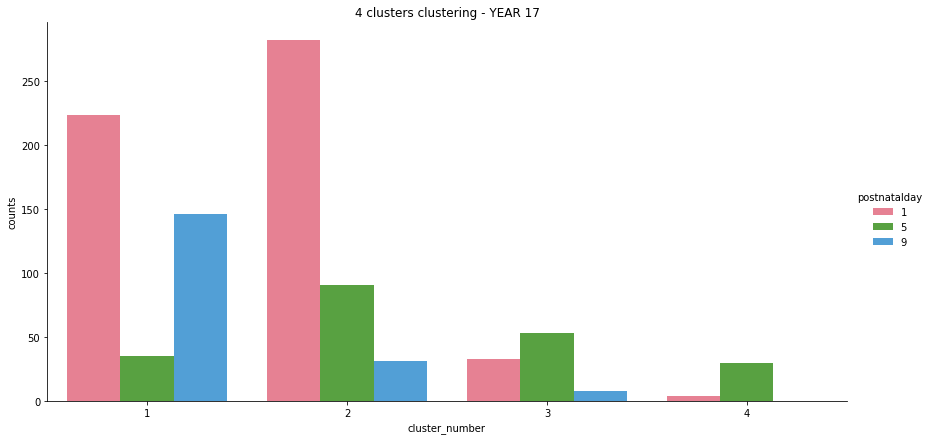

In [4]:
for c in CLUSTERS:
        tmp = df_clusters[['postnatalday', f"clust{c}", "event"]]
        tmp = tmp.groupby(['postnatalday', f"clust{c}"]).count()
        tmp.reset_index(inplace=True)
        tmp.rename({'event': 'counts', f"clust{c}": "cluster_number"}, axis=1, inplace=True)
        g = sns.catplot(x="cluster_number", y="counts", hue="postnatalday", data=tmp,
                height=6, aspect=2, kind="bar", palette=COLORS["postnatalday"])
        plt.title(f'{c} clusters clustering - YEAR {YEAR}')

Get data, audio features and merge with clusters

In [5]:
# full
csv_path = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
cache_folder = '/home/utilisateur/Desktop/palomars/cache/full_dataset'
xlsx_folder = "/home/utilisateur/Desktop/palomars/data/full/xlsx_files"
audio_folder = "/media/utilisateur/LACIE SHARE/paloma-USV-data/audio"

df = get_dataframe(
    xlsx_folder=xlsx_folder,
    audio_folder=audio_folder,
    csv_path=csv_path,
    save=True
)
print(f"Nb audibles = {len(df[df.vocalization == 1])}")
print(f"Nb USVs = {len(df[df.vocalization == 2])}")
print(f"Audible events represents the {len(df[df.vocalization == 1])/len(df)}% of total.")

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings
Nb audibles = 2204
Nb USVs = 2013
Audible events represents the 0.522646431112165% of total.


In [6]:
dataset = get_dataset(
    csv_path=csv_path,
    cache_folder=cache_folder,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


Get data and audio features and merge

In [7]:
keys =  [
    'vocalization',
    'mother',
    'year',
    'nest',
    'event',
    'postnatalday',
    'mean_sbw',
    'mean_sc',
    'mean_sf',
    'mean_zrc',
]
df = pd.DataFrame.from_records([
    {k: dec(sample[k].numpy()) for k in keys}
    for sample in dataset
]).rename({
    'mean_sbw': 'mean_spectral_band_width',
    'mean_sc': 'mean_spectral_centroid',
    'mean_sf': 'mean_spectral_flatness',
    'mean_zrc': 'mean_zero_crossing_rate'
}, axis=1)

df.head()

,vocalization,mother,year,nest,event,postnatalday,mean_spectral_band_width,mean_spectral_centroid,mean_spectral_flatness,mean_zero_crossing_rate
0,2,E,19,E3,9,1,20303.414062,67187.867188,0.004164,0.504169
1,2,E,19,E3,11,1,33599.847656,64034.972656,0.209488,0.519343
2,2,E,19,E3,5,1,27601.744141,61757.261719,0.028362,0.451025
3,1,E,19,E3,14,1,30017.888672,27213.066406,0.015524,0.104209
4,2,E,19,E3,8,1,24235.062500,63779.078125,0.012117,0.472212


In [8]:
keys =  [
    'vocalization',
    'mother',
    'year',
    'nest',
    'event',
    'postnatalday',
]
df_all = pd.merge(df_clusters[keys+[f'clust{CLUSTERS[0]}']], df, how='inner', on=keys)
df_all.head()

,vocalization,mother,year,nest,event,postnatalday,clust4,mean_spectral_band_width,mean_spectral_centroid,mean_spectral_flatness,mean_zero_crossing_rate
0,1,U,17,U4,3,5,2,31781.425781,45586.218750,0.124076,0.243988
1,1,U,17,U4,3,5,2,34401.140625,50194.382812,0.209421,0.326026
2,1,U,17,U4,3,5,2,31781.425781,45586.218750,0.124076,0.243988
3,1,U,17,U4,3,5,2,34401.140625,50194.382812,0.209421,0.326026
4,1,U,17,U4,6,5,2,32624.539062,48574.375000,0.190780,0.316695


Do plots

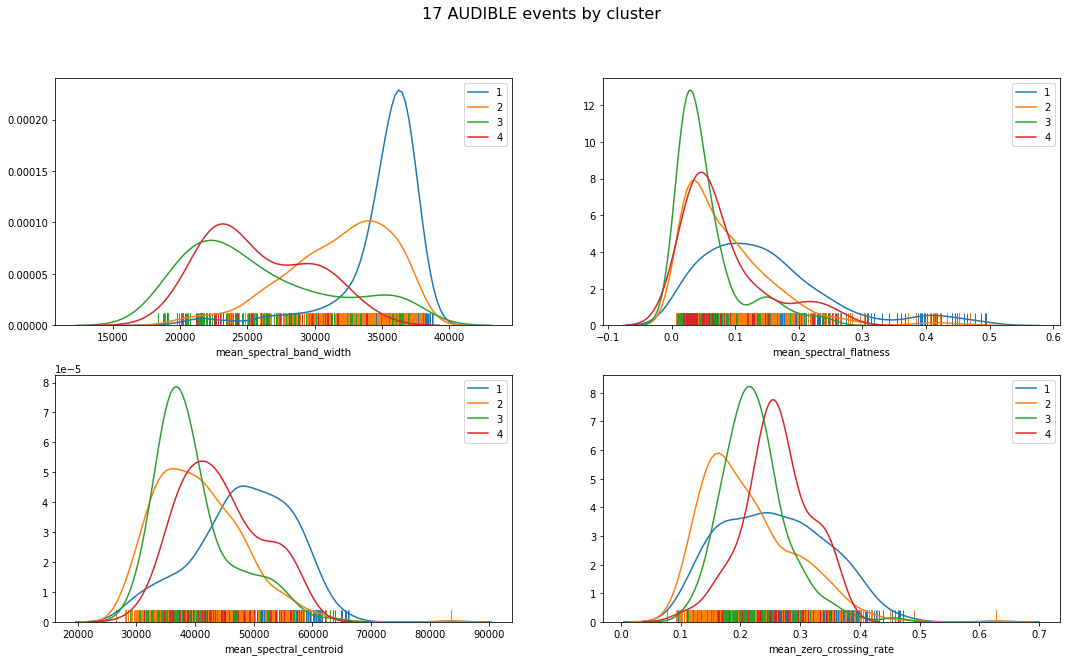

In [9]:
CLUSTERS = range(1, 5)

C = {
    c: df_all[(df_all[f'clust{CLUSTERS[-1]}'] == c) & (df_all.vocalization == 1)]
    for c in CLUSTERS
}

if True:

    f, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=False)
    title = f'{YEAR} AUDIBLE events by cluster'
    f.suptitle(title, fontsize=16)

    for c in CLUSTERS:
        sns.distplot(C[c].mean_spectral_band_width,  hist=False, rug=True, ax=axes[0, 0], kde_kws={"label": f"{c}"})

    for c in CLUSTERS:
        sns.distplot(C[c].mean_spectral_flatness,  hist=False, rug=True, ax=axes[0, 1], kde_kws={"label": f"{c}"})

    for c in CLUSTERS:
        sns.distplot(C[c].mean_spectral_centroid,  hist=False, rug=True, ax=axes[1, 0], kde_kws={"label": f"{c}"})

    for c in CLUSTERS:
        sns.distplot(C[c].mean_zero_crossing_rate,  hist=False, rug=True, ax=axes[1, 1], kde_kws={"label": f"{c}"})
        
